SSD7 MODEL

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
proj_path = "/content/drive/My Drive/AIML/data/capstone/"

import os, sys # 2nd way
os.chdir(proj_path)

# Add the path to the sys.path for this session
sys.path.append(proj_path)


In [4]:
pip install pydicom

     |████████████████████████████████| 1.9MB 4.4MB/s 


In [5]:
# Imports
import pandas as pd, numpy as np, matplotlib.pyplot as plt, sklearn, re, random

import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import pydicom as dcm
%matplotlib inline

import matplotlib.gridspec as gridspec
from tqdm.notebook import tqdm
import tensorflow, cv2
%matplotlib inline

# Extract content from zipfile
from zipfile import ZipFile

# Model
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential, Model
from sklearn.svm import SVC

# Encode, standardize and PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

# Set random_state
random_state = 2020

# Suppress warnings, if any
import warnings; warnings.filterwarnings('ignore')

# Print versions
print(f'Pandas version: {pd.__version__}')
print(f'Numpy version: {np.__version__}')
print(f'Scikit-learn version: {sklearn.__version__}')
print(f'Tensorflow version: {tensorflow.__version__}')
print(f'CV version: {cv2.__version__}')

Pandas version: 1.1.5
Numpy version: 1.19.5
Scikit-learn version: 0.22.2.post1
Tensorflow version: 2.4.1
CV version: 4.1.2


In [6]:
class_info_df = pd.read_csv('stage_2_detailed_class_info.csv')
train_labels_df = pd.read_csv('stage_2_train_labels.csv') 

In [7]:
train_labels_df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [8]:
print(f"Detailed class info -  rows: {class_info_df.shape[0]}, columns: {class_info_df.shape[1]}")
print(f"Train labels -  rows: {train_labels_df.shape[0]}, columns: {train_labels_df.shape[1]}")

Detailed class info -  rows: 30227, columns: 2
Train labels -  rows: 30227, columns: 6


In [9]:
merge_train_df = train_labels_df.merge(class_info_df, left_on='patientId', right_on='patientId', how='inner')

merge_train_df.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


In [10]:
#merge_bb_df = merge_train_df.drop(columns = ["patientId", "class"])

## Impute NaN with KNN mean
#from sklearn.impute import KNNImputer
#imputer = KNNImputer(n_neighbors=2)
#merge_bb_imputed_df = imputer.fit_transform(merge_bb_df)

## Converted array to dataframe
#merge_bb_final = pd.DataFrame(data=merge_bb_imputed_df, columns=["x", "y", "width", "height", "Target"])
#merge_bb_final["Target"] = merge_bb_final["Target"].astype('int64')
#merge_bb_final.head(5)

(1024, 1024)

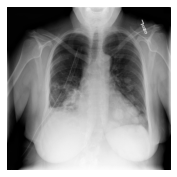

In [12]:
samplePatientID = list(merge_train_df[:3].T.to_dict().values())[0]['patientId']
samplePatientID = samplePatientID+'.dcm'
dicom_file_path = os.path.join('stage_2_train_images',samplePatientID)
dicom_file_dataset = dcm.read_file(dicom_file_path)

im = dicom_file_dataset.pixel_array

pl, ax = plt.subplots(nrows=1,figsize=(6,3))
plt.imshow(im, cmap=plt.cm.gist_gray)
plt.gray()
plt.axis('off')
im.shape

In [264]:
 def transform_boxes(boxes):
        image_height, image_width = (256,256)
        datum=pd.DataFrame()
        datum['xmin'] = (boxes['x'] - (boxes['width']) / 2) * (image_width / 1024)
        datum['ymin'] = (boxes['y'] - (boxes['height']) / 2) * (image_height / 1024)
        datum['xmax'] = (boxes['x'] + (boxes['width']) / 2) * (image_width / 1024)
        datum['ymax'] = (boxes['y'] + (boxes['height']) / 2) * (image_height / 1024)
        
        return (datum)


 def transform_boxes1(boxes):
        datum=pd.DataFrame()
        datum['xmin'] = boxes['x']
        datum['ymin'] = boxes['y']
        datum['xmax']=boxes['x']+boxes['width']
        datum['ymax']=boxes['y']+boxes['height']
        return (datum)

In [265]:
boxes1= merge_train_df.loc[(merge_train_df['Target']==1)]
boxes1 = boxes1.dropna()[['x', 'y', 'width', 'height']].astype(int)
boxes1

,x,y,width,height
4,264,152,213,379
5,264,152,213,379
6,562,152,256,453
7,562,152,256,453
10,323,577,160,104
...,...,...,...,...
37622,185,298,228,379
37625,570,393,261,345
37626,570,393,261,345
37627,233,424,201,356


In [266]:
 bbox = transform_boxes(boxes1)
 bbox.astype(int)

,xmin,ymin,xmax,ymax
4,39,-9,92,85
5,39,-9,92,85
6,108,-18,172,94
7,108,-18,172,94
10,60,131,100,157
...,...,...,...,...
37622,17,27,74,121
37625,109,55,175,141
37626,109,55,175,141
37627,33,61,83,150


In [267]:
tmp = merge_train_df[["patientId", "class", "Target"]]
train_labels_data = pd.merge(tmp, bbox.astype(int), how= 'outer', left_index=True, right_index=True)
train_labels_data.drop_duplicates()


,patientId,class,Target,xmin,ymin,xmax,ymax
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,0,NaN,NaN,NaN,NaN
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,0,NaN,NaN,NaN,NaN
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,0,NaN,NaN,NaN,NaN
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,0,NaN,NaN,NaN,NaN
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,1,39.0,-9.0,92.0,85.0
...,...,...,...,...,...,...,...
37621,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,Lung Opacity,1,17.0,27.0,74.0,121.0
37623,c1edf42b-5958-47ff-a1e7-4f23d99583ba,Normal,0,NaN,NaN,NaN,NaN
37624,c1f6b555-2eb1-4231-98f6-50a963976431,Normal,0,NaN,NaN,NaN,NaN
37625,c1f7889a-9ea9-4acb-b64c-b737c929599a,Lung Opacity,1,109.0,55.0,175.0,141.0


In [268]:
train_labels_data = train_labels_data.replace(to_replace =["Lung Opacity"],  
                            value ="pnemonia") 

In [269]:
train_labels_data = train_labels_data.replace(to_replace =["No Lung Opacity / Not Normal"],  
                            value ="not_normal") 


In [270]:
train_labels_data = train_labels_data.replace(to_replace =["Normal"],  
                            value ="normal")

In [271]:
train_labels_data = train_labels_data.fillna(-1)

In [272]:
train_labels_data.drop_duplicates()

#train_labels_data=train_labels_data.loc[(train_labels_data['Target']==1)]



,patientId,class,Target,xmin,ymin,xmax,ymax
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,not_normal,0,-1.0,-1.0,-1.0,-1.0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,not_normal,0,-1.0,-1.0,-1.0,-1.0
2,00322d4d-1c29-4943-afc9-b6754be640eb,not_normal,0,-1.0,-1.0,-1.0,-1.0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,normal,0,-1.0,-1.0,-1.0,-1.0
4,00436515-870c-4b36-a041-de91049b9ab4,pnemonia,1,39.0,-9.0,92.0,85.0
...,...,...,...,...,...,...,...
37621,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,pnemonia,1,17.0,27.0,74.0,121.0
37623,c1edf42b-5958-47ff-a1e7-4f23d99583ba,normal,0,-1.0,-1.0,-1.0,-1.0
37624,c1f6b555-2eb1-4231-98f6-50a963976431,normal,0,-1.0,-1.0,-1.0,-1.0
37625,c1f7889a-9ea9-4acb-b64c-b737c929599a,pnemonia,1,109.0,55.0,175.0,141.0


In [273]:
train_labels_data.rename(columns = {'Target':'class_id'}, inplace = True)
train_labels_data.rename(columns = {'x':'center_x'}, inplace = True)
train_labels_data.rename(columns = {'y':'center_y'}, inplace = True)


In [274]:
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras.models import Model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline



In [275]:
# create training and validation data
folder = proj_path+'data/positive'
filenames = os.listdir(folder)

random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 1200
n_train_samples = len(filenames) - n_valid_samples
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('Total file samples:', len(filenames))
print('Train samples (80%):', len(train_filenames))
print('Valid samples (20%):', len(valid_filenames))

Total file samples: 6012
Train samples (80%): 4812
Valid samples (20%): 1200


In [276]:
tl = pd.DataFrame(train_filenames)
tl.columns = ["image_name"]
tl["patientId"] = tl["image_name"]
tl["patientId"]= tl["patientId"].str.split(".", n = 1, expand = True)
tl.head()

tldata = tl.merge(train_labels_data, on='patientId', how='inner', left_index=True, right_index=True)
tldata.drop_duplicates()
tldata.reset_index(inplace=True)
tldata = tldata.rename(columns = {'index':'id'})

In [277]:
tldata1 = tldata[["image_name","xmin","ymin","xmax","ymax","class_id"]]

In [278]:
tldata1

,image_name,xmin,ymin,xmax,ymax,class_id
0,738524e2-9e98-43cb-8c56-b480a2a0ae2f.jpg,-1.0,-1.0,-1.0,-1.0,0
1,8a546535-613f-49b1-897c-a0933c53cb84.jpg,-1.0,-1.0,-1.0,-1.0,0
2,3f30761d-5615-4039-a155-0fd26f461742.jpg,-1.0,-1.0,-1.0,-1.0,0
3,39ced0d0-246c-430d-9bea-efc60bfa487c.jpg,-1.0,-1.0,-1.0,-1.0,0
4,bea23d20-aa4e-41d5-b8e7-22941746e543.jpg,39.0,-9.0,92.0,85.0,1
...,...,...,...,...,...,...
4807,20ed5a77-bb84-4c95-b126-714bd59cdfbf.jpg,99.0,76.0,155.0,121.0,1
4808,1352a7f3-1f0d-4f1f-af05-daa5d7f8624a.jpg,48.0,49.0,85.0,101.0,1
4809,b154363c-2aa3-4f9d-a0f3-99e32ca63289.jpg,48.0,49.0,85.0,101.0,1
4810,6222228a-e831-40b9-8d5e-eed896717642.jpg,123.0,60.0,170.0,130.0,1


In [279]:
#base_filename = 'tldata.csv'
#with open(os.path.join(proj_path, base_filename),'w') as outfile:
#   tldata1.to_csv(outfile)

In [280]:
vl = pd.DataFrame(valid_filenames)
vl.columns = ["image_name"]
vl["patientId"] = vl["image_name"]
vl["patientId"]= vl["patientId"].str.split(".", n = 1, expand = True)
vl.head()

vldata = vl.merge(train_labels_data, on='patientId', how='inner', left_index=True, right_index=True)
vldata.drop_duplicates()
vldata.reset_index(inplace=True)
vldata = vldata.rename(columns = {'index':'id'})

In [281]:
vldata1 = vldata[["image_name","xmin","ymin","xmax","ymax","class_id"]]

In [282]:
#base_filename = 'vldata.csv'
#with open(os.path.join(proj_path, base_filename),'w') as outfile:
#   vldata1.to_csv(outfile)

In [ ]:
data_dir = proj_path+'data/positive'
train_image_dir = proj_path+'test_train/'
val_image_dir = proj_path+'test_val/'
train_annotations_file = proj_path+'tldata.csv'
val_annotations_file = proj_path+'vldata.csv'


In [283]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf

In [284]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, CSVLogger
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd7 import build_model
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from data_generator.data_augmentation_chain_variable_input_size import DataAugmentationVariableInputSize
from data_generator.data_augmentation_chain_constant_input_size import DataAugmentationConstantInputSize
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation

%matplotlib inline

In [285]:
img_height = 256
img_width = 256
img_channels =3

intensity_mean = 127.5
intensity_range = 127.5

n_classes = 5
scales = [0.08, 0.16, 0.32, 0.64, 0.96]
aspect_ratios = [0.5, 1.0, 2.0]
two_boxes_for_ar1 = True
steps = None
offsets = None
clip_boxes = False
variances = [1.0, 1.0, 1.0, 1.0]
normalize_coords = True

In [286]:
K.clear_session()

model = build_model(image_size=(img_height, img_width, img_channels),
                    n_classes=n_classes,
                    mode='training',
                    l2_regularization=0.0005,
                    scales=scales,
                    aspect_ratios_global=aspect_ratios,
                    aspect_ratios_per_layer=None,
                    two_boxes_for_ar1=two_boxes_for_ar1,
                    steps=steps,
                    offsets=offsets,
                    clip_boxes=clip_boxes,
                    variances=variances,
                    normalize_coords=normalize_coords,
                    subtract_mean=intensity_mean,
                    divide_by_stddev=intensity_range)

In [287]:
model.load_weights(proj_path +'ssd7_weights.h5')

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [288]:
train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)

In [289]:
images_dir = proj_path+'data/positive/'

train_labels_filename = proj_path+'tldata.csv'
val_labels_filename   = proj_path+'vldata.csv'


In [290]:
train_dataset.parse_csv(images_dir=images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                        include_classes='all')

val_dataset.parse_csv(images_dir=images_dir,
                      labels_filename=val_labels_filename,
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                      include_classes='all')

In [291]:
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the training dataset:	  4812
Number of images in the validation dataset:	  1200


In [292]:
batch_size = 32

data_augmentation_chain = DataAugmentationConstantInputSize(random_brightness=(-48, 48, 0.5),
                                                            random_contrast=(0.5, 1.8, 0.5),
                                                            random_saturation=(0.5, 1.8, 0.5),
                                                            random_hue=(18, 0.5),
                                                            random_flip=0.5,
                                                            random_translate=((0.03,0.5), (0.03,0.5), 0.5),
                                                            random_scale=(0.5, 2.0, 0.5),
                                                            n_trials_max=3,
                                                            clip_boxes=True,
                                                            overlap_criterion='area',
                                                            bounds_box_filter=(0.3, 1.0),
                                                            bounds_validator=(0.5, 1.0),
                                                            n_boxes_min=1,
                                                            background=(0,0,0))


In [293]:
predictor_sizes = [model.get_layer('classes4').output_shape[1:3],
                   model.get_layer('classes5').output_shape[1:3],
                   model.get_layer('classes6').output_shape[1:3],
                   model.get_layer('classes7').output_shape[1:3]]

In [294]:
ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_global=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.3,
                                    normalize_coords=normalize_coords)

In [295]:
train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[data_augmentation_chain],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

In [296]:
model_checkpoint = ModelCheckpoint(filepath='ssd7_weights.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto')

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.0,
                               patience=10,
                               verbose=1)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.2,
                                         patience=8,
                                         verbose=1,
                                         min_delta=0.001,
                                         cooldown=0,
                                         min_lr=0.00001)

callbacks = [model_checkpoint,
             early_stopping,
             reduce_learning_rate]


In [297]:
def train(model):
    initial_epoch   = 0
    final_epoch     = 20
    steps_per_epoch = 1000

    history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=steps_per_epoch,
                                epochs=final_epoch,
                                callbacks=callbacks,
                                validation_data=val_generator,
                                validation_steps=ceil(val_dataset_size/batch_size),
                                initial_epoch=initial_epoch)

    plt.figure(figsize=(20,12))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend(loc='upper right', prop={'size': 24})

    return model

In [298]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
identity_layer (Lambda)         (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
input_mean_normalization (Lambd (None, 256, 256, 3)  0           identity_layer[0][0]             
__________________________________________________________________________________________________
input_stddev_normalization (Lam (None, 256, 256, 3)  0           input_mean_normalization[0][0]   
______________________________________________________________________________________________

In [299]:
predict_generator = val_dataset.generate(batch_size=32,
                                         shuffle=True,
                                         transformations=[],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'processed_labels',
                                                  'filenames'},
                                         keep_images_without_gt=False)


In [352]:
batch_images, batch_labels, batch_filenames = next(predict_generator)
i = 4
print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(batch_labels[i])

Image: /content/drive/My Drive/AIML/data/capstone/data/positive/6f3d76ce-9c4e-4e4c-b344-776d764e1be8.jpg

Ground truth boxes:

[[  1  27  81 112 170]]


In [353]:
y_pred = model.predict(batch_images)

In [354]:
# 4: Decode the raw prediction `y_pred`

y_pred_decoded = decode_detections(y_pred * 266.,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.45,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[    2.      44.33 30260.16 51540.16 35707.84 56987.84]
 [    2.      44.33 65105.95 52539.91 68958.05 60244.09]
 [    2.      44.33   468.16 55796.16  5915.84 61243.84]
 ...
 [    2.      44.33 22545.96 61051.91 26398.04 68756.09]
 [    2.      44.33 24673.96 61051.91 28526.04 68756.09]
 [    5.      44.33 37793.28 37793.28 81374.72 81374.72]]


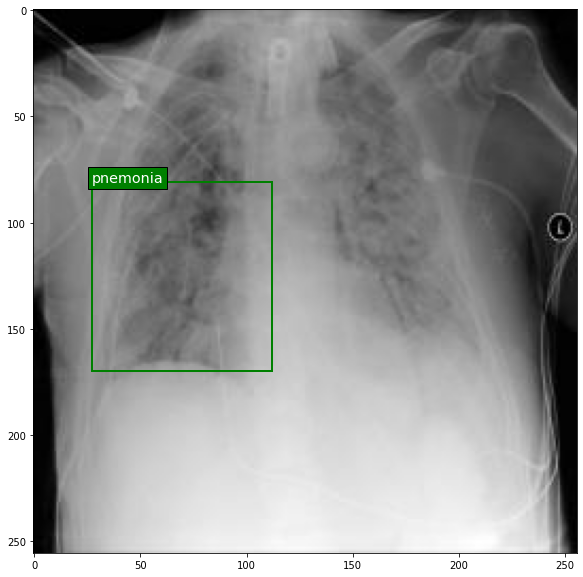

In [355]:
plt.figure(figsize=(10,10))
plt.imshow(batch_images[i])

current_axis = plt.gca()

colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()
classes = ['background', 'pnemonia','Normal','not normal','no opacity','opacity']

for box in batch_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for box in y_pred_decoded[i]:
    xmin = box[-4]
    ymin = box[-3]
    xmax = box[-2]
    ymax = box[-1]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))